# Diego Jafet Garza Segovia - LDA y árboles de decisión

Dentro de este documento, se estara trabajando con la base de datos de "Breast Cancer Wisconsin (Diagnostic)". La base de datos puede ser descargada directamente desde [UCI Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

Se estará buscando analizar la variable "target" (diagnosis), el cual dicta si el diagnostico de una masa es maligna o benigna (1 / 0). Las variables de esta base de datos se dividen en 3 partes, mean / error / worst, las cuales describen distintas caracteristicas de las siguientes variables:

- radius
- texture
- perimeter
- area
- smoothness
- compactness
- concavity 
- concave points
- symmetry 
- fractal dimension

Para realizar el modelo LDA y el árbol de decisión de esta base de datos, primero se debera importar este mismo al ambiente de trabajo, el cual ya se encuentra presente dentro de sklearn.datasets. 

Posteriormente, para poder comprobar los resultados se dividiran los datos aleatoriamente en datos de entrenamiento y prueba (80% - 20%) mediante la función train_test_split. Se incluira el parametro stratify para mantener una proporcion equivalente de clases en ambos grupos de datos.

In [75]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(df.drop(columns = "target"), df.target, train_size = 0.8, stratify = df.target)

print("Original:\n", df.target.value_counts(normalize = True))
print("\nEntrenamiento:\n", yTrain.value_counts(normalize = True))
print("\nPrueba:\n", yTest.value_counts(normalize = True))

Original:
 target
1    0.627417
0    0.372583
Name: proportion, dtype: float64

Entrenamiento:
 target
1    0.626374
0    0.373626
Name: proportion, dtype: float64

Prueba:
 target
1    0.631579
0    0.368421
Name: proportion, dtype: float64


Se puede ver que tanto en los datos originales como los de entrenamiento y prueba, hay una proporicion aproximada del 63% y 37% de datos 1's y 0's en cada grupo de datos, manteniendo un balance de clases.

Debido a que la base de datos incluye 32 variables, para minimizar el costo computacional de analizar todas se generara una regresión logística simple con la funcion GLM de statsmodels, y de según los resultados obtenidos, 2 de estas variables seran seleccionadas como las más relevantes para este estudio, eliminando todas las demás variables.

In [77]:
import statsmodels.api as sm

xTrain = sm.add_constant(xTrain)
modelo = sm.GLM(yTrain, xTrain, family = sm.families.Binomial()).fit()

print(modelo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  455
Model:                            GLM   Df Residuals:                      424
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 03 Oct 2025   Deviance:                   2.8315e-09
Time:                        07:58:43   Pearson chi2:                 1.42e-09
No. Iterations:                    30   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    4

C:\Users\whati\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\whati\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\whati\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\whati\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\whati\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342:

Debido a que se muestra una advertencia que se detecto una separación perfecta, no se podrá elegir las variables según su P-value, sino mediante su valor del coeficiente (se tomara en consideración el valor absoluto).

In [80]:
coef = modelo.params.drop("const") 

top2 = coef.abs().sort_values(ascending=False).head(2)

print("\nLas dos variables con mayor valor absoluto del coeficiente son:")
print(top2)


Las dos variables con mayor valor absoluto del coeficiente son:
fractal dimension error    47595.810876
concave points error       26026.870556
dtype: float64


Las dos variables mas relevantes para este estudio, tomando en consideración el coeficiente de estos como base, son "fractal dimension error" y "concave points error". Los datos de entrenamiento y prueba en x seran limitadas a estas variables, y posteriormente se generara un modelo usando la metodologia de linear discriminant analysis.

Adicionalmente, los datos de entrenamiento y prueba seran escalados mediante el uso de StandardScaler de sklearn.preprocessing, con el proposito de disminuir la influencia que pueda tener una variable sobre la otra debido a diferencia de magnitudes.

C:\Users\whati\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


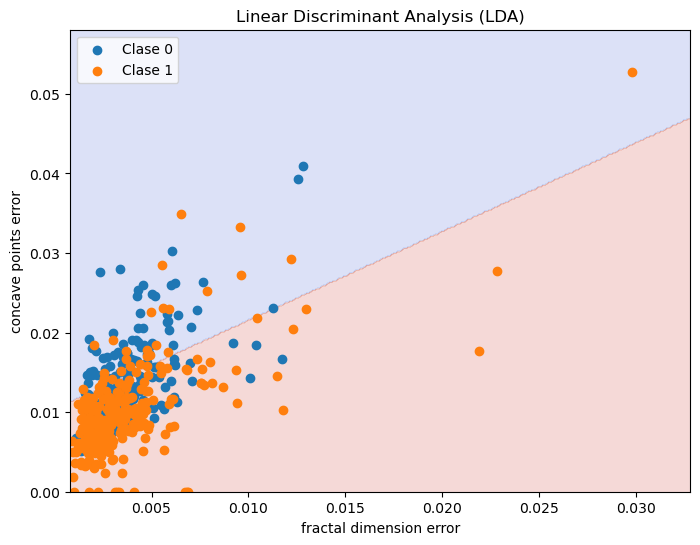

In [84]:
xTrain = xTrain[['fractal dimension error', 'concave points error']]
xTest = xTest[['fractal dimension error', 'concave points error']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xTest_scaled = scaler.transform(xTest)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

ldaModel = LDA().fit(xTrain_scaled, yTrain)
import matplotlib.pyplot as plt
import numpy as np
x_min, x_max = df['fractal dimension error'].min()*0.9, df['fractal dimension error'].max()*1.1
y_min, y_max = df['concave points error'].min()*0.9, df['concave points error'].max()*1.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler.transform(grid)
Z = ldaModel.predict(grid_scaled).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')

for cls in np.unique(yTrain):
    plt.scatter(
        xTrain[yTrain==cls]['fractal dimension error'],
        xTrain[yTrain==cls]['concave points error'],
        label = f'Clase {cls}'
    )

plt.xlabel('fractal dimension error')
plt.ylabel('concave points error')
plt.title("Linear Discriminant Analysis (LDA)")
plt.legend()
plt.show()

En la gráfica anterior, a pesar de que se puede notar una clara concentración de datos entre los rangos {0.00, 0.01} (fractal dimension error) y {0.00, 0.02} (concave points error), tambien se puede ver una leve diferencia de la posición de dichos datos segun si pertenecen a la 0 o 1. 

Esta diferencia se puede notar por el fondo de la gráfica, el cual muestra un separador en diagonal donde predice que es mas probable que los datos en la mitad superior pertenezcan a los datos de clase 0, mientras que en la mitad inferior a los de la clase 1.

Ahora, se hara un nuevo modelo usando la metodología de árboles de decisión. El árbol generado sera podado tras haber seleccionado un valor óptimo de alpha mediante la metodología de LOOCV (Leave-One-Out). Adicionalmente, se volvera a mostrar una gráfica que representa las distintas divisiones (hojas) creadas.


Arbol despues de poda:



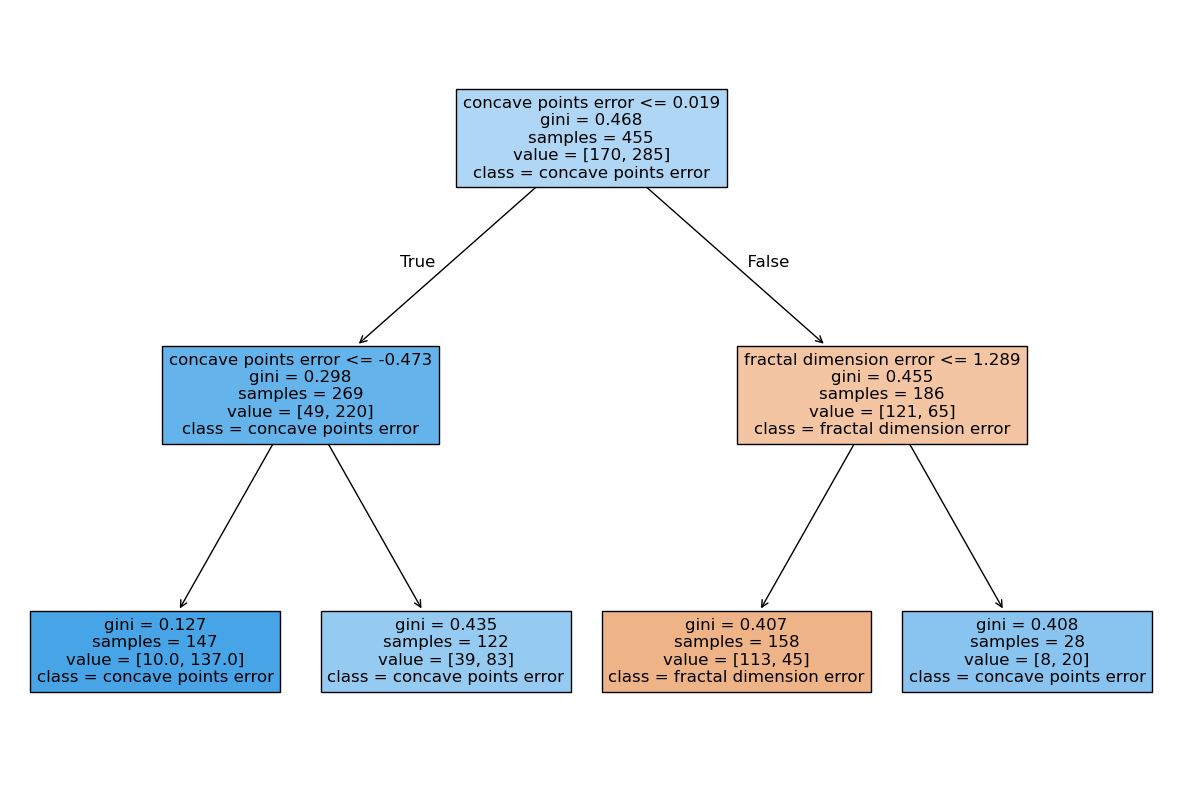

C:\Users\whati\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


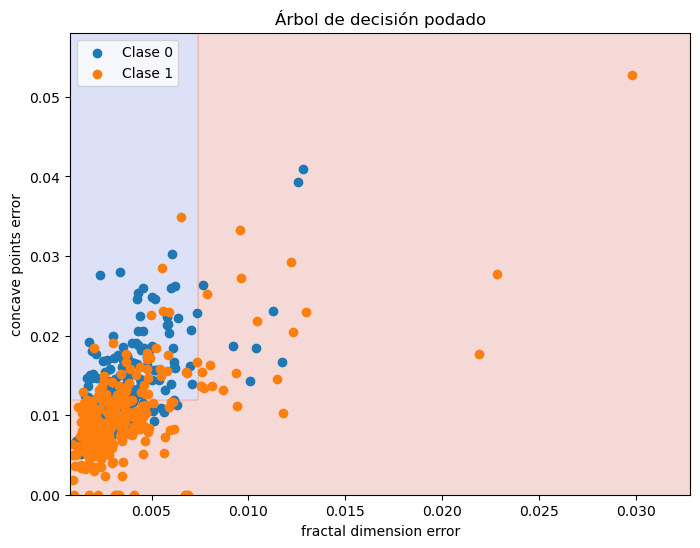

In [85]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier as DTC

tree = DTC().fit(xTrain_scaled, yTrain)

skf = StratifiedKFold(n_splits=4)
ccp = np.linspace(0.001, 0.2, 250)
cv_scores = []
for alpha in ccp:
      pruned_tree = DTC(ccp_alpha=alpha)
      cv_scores.append(np.mean(cross_val_score(pruned_tree, xTrain, yTrain, cv=skf, scoring='f1')))
alpha = ccp[np.argmax(cv_scores)]

pruned_tree = DTC(ccp_alpha = alpha).fit(xTrain_scaled, yTrain)

print("\nArbol despues de poda:\n")

%matplotlib inline
plt.figure(figsize=(15,10))
plot_tree(pruned_tree, 
          filled = True, 
          feature_names = xTrain.columns, 
          class_names = ["fractal dimension error", "concave points error"])
plt.show()

# Graficar la partición del árbol podado en 2D (similar al gráfico de LDA)
x_min, x_max = df['fractal dimension error'].min()*0.9, df['fractal dimension error'].max()*1.1
y_min, y_max = df['concave points error'].min()*0.9, df['concave points error'].max()*1.1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler.transform(grid)   # Escalar como en entrenamiento

Z = pruned_tree.predict(grid_scaled).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')

for cls in np.unique(yTrain):
    plt.scatter(
        xTrain[yTrain==cls]['fractal dimension error'],
        xTrain[yTrain==cls]['concave points error'],
        label = f'Clase {cls}'
    )

plt.xlabel('fractal dimension error')
plt.ylabel('concave points error')
plt.title("Árbol de decisión podado")
plt.legend()
plt.show()


Según la gráfica generada a partir del modelo generado usando la metodología de árboles de decisión, es mucho mas probable que el modelo prediga que un dato pertenece a la clase 1 por encima que la clase 0, siendo que unicamente predicira que es 0 en un rango corto de (aproximadamente) {0.00, 0.075} (fractal dimension error) a {0.012 - 0.06}.

Sin embargo, esto no significa necesariamente que el modelo generado sea de mala calidad, ya que estos nuevos datos se ven relacionados con las proporciones originales de datos en la base de datos, siendo que el 67% de los datos aproximadamente son 1.

Para obtener mejores resultados, o resultados mas "balanceados", seria necesario recopilar mas datos de clase 0.

Ahora, para poder medir la calidad de los modelos generados, se calcularán distintos valores que funcionaran como las métricas de calidad para ambos modelos, particularmente el accuracy, sensitivity, specificity, precision, F1 score, y su matriz de confusión.


Modelo LDA: 


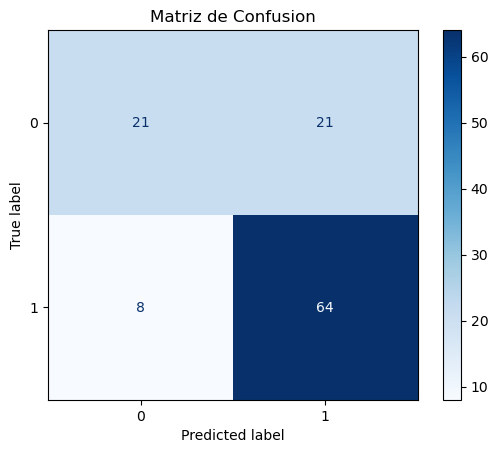


Accuracy:  0.7456140350877193
Sensitivity:  0.8888888888888888
Specificity:  0.24705882352941178
Precision:  0.7529411764705882
F1 Score:  0.8152866242038216

Modelo árbol de decisión:


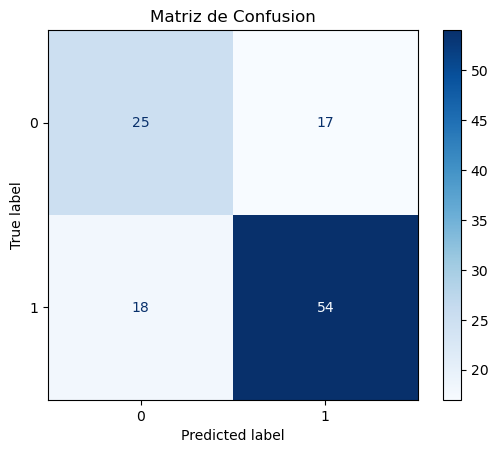


Accuracy:  0.6929824561403509
Sensitivity:  0.75
Specificity:  0.352112676056338
Precision:  0.7605633802816901
F1 Score:  0.7552447552447553


In [86]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = ldaModel.predict(xTest_scaled)
TN, FP, FN, TP = confusion_matrix(yTest, y_pred).ravel()

Acc = (TP + TN) / (TP + FP + TN + FN)
Sen = TP / (TP + FN)
Spe = TN / (TP + FP)
Pre = TP / (TP + FP)
F1S = 2*(Pre * Sen) / (Pre + Sen)

print("\nModelo LDA: ")

cm = confusion_matrix(yTest, y_pred, labels=pruned_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pruned_tree.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusion")
plt.show()

print("\nAccuracy: ", Acc)
print("Sensitivity: ", Sen)
print("Specificity: ", Spe)
print("Precision: ", Pre)
print("F1 Score: ", F1S)

print ("\nModelo árbol de decisión:")

y_pred = pruned_tree.predict(xTest_scaled)
TN, FP, FN, TP = confusion_matrix(yTest, y_pred).ravel()

Acc = (TP + TN) / (TP + FP + TN + FN)
Sen = TP / (TP + FN)
Spe = TN / (TP + FP)
Pre = TP / (TP + FP)
F1S = 2*(Pre * Sen) / (Pre + Sen)

cm = confusion_matrix(yTest, y_pred, labels=pruned_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pruned_tree.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusion")
plt.show()

print("\nAccuracy: ", Acc)
print("Sensitivity: ", Sen)
print("Specificity: ", Spe)
print("Precision: ", Pre)
print("F1 Score: ", F1S)

En los datos calculados, se puede ver primeramente en el modelo LDA que este tiene 64 verdareros positivos, 21 falsos positivos, 21 verdaderos negativos y 8 falsos negativos. 

En general, representa que acierta aproximadamente 3 de cada 4 predicciones (accuracy), y que es particularmente bueno acertando correctamente los casos 1, teniendo una sensibilidad del 89%. Sin embargo, su especificidad es muy baja, siendo solo del 24.7%, significando que el modelo NO es bueno detectando casos 0. Aun asi, debido a la proporcion de clase de datos, se tiene un balance del 81.5% entre la precision y sensibilidad (F1 Score). La precision calculada es de un 76%, significando que tiene un buen nivel de confianza en los positivos.

Mientras tanto, el modelo que se genero mediante el árbol de decisión tiene un 54 en verdaderos positivos, 25 en falsos positivos, 18 en verdaderos negativos y 17 en falsos negativos.

Esto disminuye levemente el accuracy del modelo comparado al previo, siendo un 70% a diferencia de un 75%. Igualmente, su sensitivity baja en un 14% a 75%, sin embargo, la especificidad aumenta a 35%. Esto, probablemente debido a proporcion de clases en la base de datos, resulta en un F1 Score disminuido de 76%, el cual sigue siendo un porcentaje adecuado. Sin embargo, la precision del modelo no disminuyo ni aumento en comparacion al modelo LDA.

Esto significa que, el modelo del árbol de decisión no es igual de capaz como el modelo LDA para adecuadamente acertar cuando un dato pertenece a la clase 1, pero es mejor acertando sobre la clase 0. Debido a esto, se podría elegir cualquiera de los dos modelos según las necesidades del estudio, ya sea que se quiera tener una alta confianza al predecir si es maligno o reducir la probabilidad de erroneamente predecir si es maligno.

Sin embargo, debido a que trata de cancer de mama, si se quisiera reducir la probabilidad de ERRONEAMENTE NO reconocer cuando es maligno, podría ser favorable disminuir el umbral para obtener mas verdaderos positivos, aun y si se generan mas falsos positivos. Independientemente, tambien seria favorable recopilar mas datos pertenecientes a la clase 0, ya que en ambos modelos se obtuvo una especificidad MENOR al 50%, o bien, probar con distintas variables que podrían ser mas útiles en adecuadamente predecir cuando no es maligno.